In [1]:
import lightgbm as lgb

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from lightgbm.callback import early_stopping, log_evaluation
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings('ignore')

def safe_inverse_transform(scaler, arr, clip_min=-20, clip_max=20):
    arr_clipped = np.clip(arr.reshape(-1,1), clip_min, clip_max)
    inv_scaled = scaler.inverse_transform(arr_clipped)
    return np.expm1(inv_scaled.flatten())


data = pd.read_csv('Monthly_Rainfall_From_1901_to_2024_Extended.csv')
data.rename(columns={'Unnamed: 0': 'Name'}, inplace=True)
le = LabelEncoder()
data['States/UTs'] = le.fit_transform(data['States/UTs'])
for lag in range(1, 4):
    data[f'Lag_{lag}'] = data.groupby('States/UTs')['ANNUAL'].shift(lag)
data.bfill(inplace=True)

X = data.drop(columns=['YEAR', 'ANNUAL'])
y = np.log1p(data['ANNUAL'])

train_idx = int(len(X) * 0.8)
X_train_full, X_test = X[:train_idx], X[train_idx:]
y_train_full, y_test = y[:train_idx], y[train_idx:]

scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train_full)
X_test_scaled = scaler_X.transform(X_test)
imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_full.values.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()

selector = SelectKBest(score_func=f_regression, k=min(20, X_train_scaled.shape[1]))
X_train_selected = selector.fit_transform(X_train_scaled, y_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

z_scores = np.abs(stats.zscore(X_train_selected))
keep_idx = (z_scores < 3).all(axis=1)
X_train_clean = X_train_selected[keep_idx]
y_train_clean = y_train_scaled[keep_idx]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list_lgbm, mae_list_lgbm, r2_list_lgbm = [], [], []
rmse_list_lstm, mae_list_lstm, r2_list_lstm = [], [], []
rmse_list_hybrid, mae_list_hybrid, r2_list_hybrid = [], [], []

all_y_val_true = []
all_lgbm_val_preds = []
all_lstm_val_preds = []
all_hybrid_val_preds = []

for train_index, val_index in kf.split(X_train_clean):
    X_train, X_val = X_train_clean[train_index], X_train_clean[val_index]
    y_train, y_val = y_train_clean[train_index], y_train_clean[val_index]

    lgbm_model = lgb.LGBMRegressor(random_state=42, n_estimators=1000, learning_rate=0.03,
                                  max_depth=3, num_leaves=31, subsample=0.8, colsample_bytree=0.8,
                                  reg_alpha=0.1, reg_lambda=0.1)
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
    )

    lgbm_val_preds = lgbm_model.predict(X_val)
    y_val_true = scaler_y.inverse_transform(y_val.reshape(-1,1)).flatten()
    lgbm_val_preds_true = scaler_y.inverse_transform(lgbm_val_preds.reshape(-1,1)).flatten()

    rmse_list_lgbm.append(np.sqrt(mean_squared_error(y_val_true, lgbm_val_preds_true)))
    mae_list_lgbm.append(mean_absolute_error(y_val_true, lgbm_val_preds_true))
    r2_list_lgbm.append(r2_score(y_val_true, lgbm_val_preds_true))

    X_train_lstm = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_val_lstm = X_val.reshape(X_val.shape[0],1,X_val.shape[1])
    lstm_model = Sequential([
        Input(shape=(1,X_train.shape[1])),
        Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
        Dropout(0.5),
        LSTM(64, activation='tanh'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    lstm_model.fit(X_train_lstm, y_train,
                   epochs=100, batch_size=16,
                   validation_data=(X_val_lstm, y_val),
                   callbacks=[ReduceLROnPlateau('val_loss', factor=0.5, patience=5),
                              EarlyStopping('val_loss', patience=10, restore_best_weights=True)],
                   verbose=0)
    lstm_val_preds = lstm_model.predict(X_val_lstm).flatten()
    lstm_val_preds_true = scaler_y.inverse_transform(lstm_val_preds.reshape(-1,1)).flatten()
    rmse_list_lstm.append(np.sqrt(mean_squared_error(y_val_true, lstm_val_preds_true)))
    mae_list_lstm.append(mean_absolute_error(y_val_true, lstm_val_preds_true))
    r2_list_lstm.append(r2_score(y_val_true, lstm_val_preds_true))

    total_inv = 1/(np.sqrt(mean_squared_error(y_val_true, lstm_val_preds_true))) + 1/(np.sqrt(mean_squared_error(y_val_true, lgbm_val_preds_true)))
    w_lstm = (1/(np.sqrt(mean_squared_error(y_val_true, lstm_val_preds_true)))) / total_inv
    w_lgbm = (1/(np.sqrt(mean_squared_error(y_val_true, lgbm_val_preds_true)))) / total_inv

    hybrid_val_preds_true = w_lstm * lstm_val_preds_true + w_lgbm * lgbm_val_preds_true
    rmse_list_hybrid.append(np.sqrt(mean_squared_error(y_val_true, hybrid_val_preds_true)))
    mae_list_hybrid.append(mean_absolute_error(y_val_true, hybrid_val_preds_true))
    r2_list_hybrid.append(r2_score(y_val_true, hybrid_val_preds_true))

    all_y_val_true.append(y_val_true)
    all_lgbm_val_preds.append(lgbm_val_preds_true)
    all_lstm_val_preds.append(lstm_val_preds_true)
    all_hybrid_val_preds.append(hybrid_val_preds_true)

print("Average Metrics Over Folds:")
print(f"LightGBM RMSE: {np.mean(rmse_list_lgbm):.4f}, MAE: {np.mean(mae_list_lgbm):.4f}, R2: {np.mean(r2_list_lgbm):.4f}")
print(f"LSTM RMSE: {np.mean(rmse_list_lstm):.4f}, MAE: {np.mean(mae_list_lstm):.4f}, R2: {np.mean(r2_list_lstm):.4f}")
print(f"Hybrid RMSE: {np.mean(rmse_list_hybrid):.4f}, MAE: {np.mean(mae_list_hybrid):.4f}, R2: {np.mean(r2_list_hybrid):.4f}")

y_val_full = np.concatenate(all_y_val_true)
lgbm_val_preds_full = np.concatenate(all_lgbm_val_preds)
lstm_val_preds_full = np.concatenate(all_lstm_val_preds)
hybrid_val_preds_full = np.concatenate(all_hybrid_val_preds)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3854
[LightGBM] [Info] Number of data points in the train set: 2360, number of used features: 16
[LightGBM] [Info] Start training from score 0.586819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
# Feature importance for final LightGBM model (uses selected features)
importances = lgbm_model.feature_importances_
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]

feat_imp_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance (LightGBM - Top 10 Selected Features):")
print(feat_imp_df.head(10))


Feature Importance (LightGBM - Top 10 Selected Features):
   Feature  Importance
7      JUL         799
8      AUG         638
6      JUN         591
14   Lag_2         575
15   Lag_3         573
9      SEP         527
13   Lag_1         507
10     OCT         399
5      MAY         382
11     NOV         316


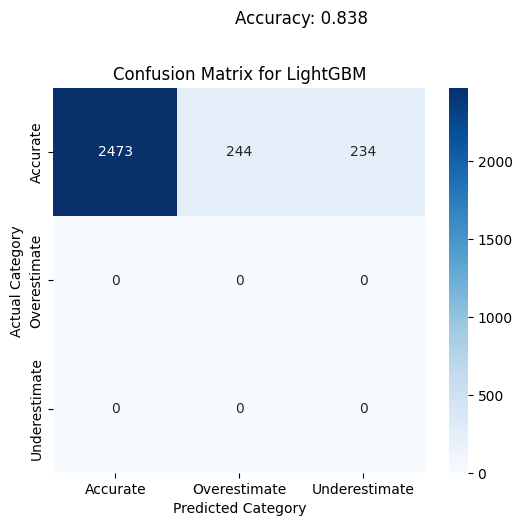

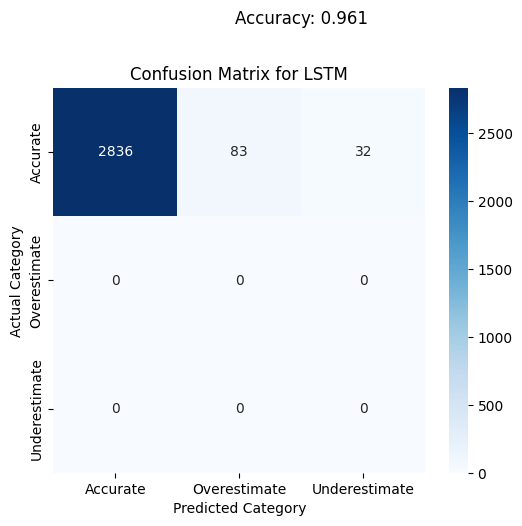

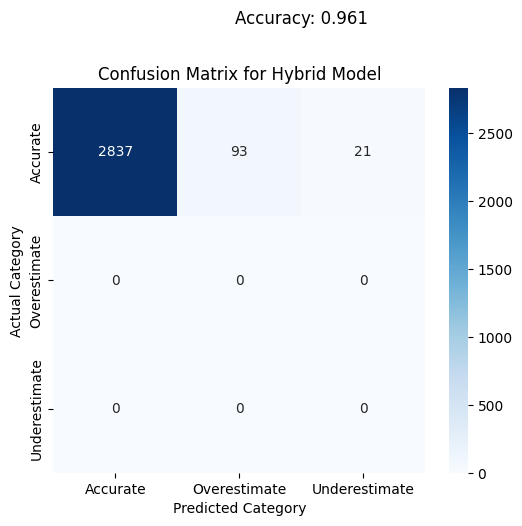

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def categorize_predictions(y_true, y_pred, tolerance=0.01):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    errors = y_pred - y_true
    base = np.where(y_true == 0, np.mean(y_true), y_true)
    within_tolerance = np.abs(errors) <= (tolerance * base)
    overestimate = errors > (tolerance * base)
    underestimate = errors < -(tolerance * base)
    categories = np.zeros_like(errors, dtype=int)
    categories[within_tolerance] = 0
    categories[overestimate] = 1
    categories[underestimate] = 2
    return categories

def plot_confusion_matrix(y_true, y_pred, model_name, tolerance=0.01):
    y_true_cat = categorize_predictions(y_true, y_true, tolerance)
    y_pred_cat = categorize_predictions(y_true, y_pred, tolerance)
    cm = confusion_matrix(y_true_cat, y_pred_cat, labels=[0,1,2])
    labels = ['Accurate', 'Overestimate', 'Underestimate']
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel("Predicted Category")
    plt.ylabel("Actual Category")
    plt.title(f"Confusion Matrix for {model_name}")
    acc = accuracy_score(y_true_cat, y_pred_cat)
    plt.text(2, -0.5, f'Accuracy: {acc:.3f}', fontsize=12, ha='center')
    plt.show()


plot_confusion_matrix(y_val_full, lgbm_val_preds_full, "LightGBM")
plot_confusion_matrix(y_val_full, lstm_val_preds_full, "LSTM")
plot_confusion_matrix(y_val_full, hybrid_val_preds_full, "Hybrid Model")


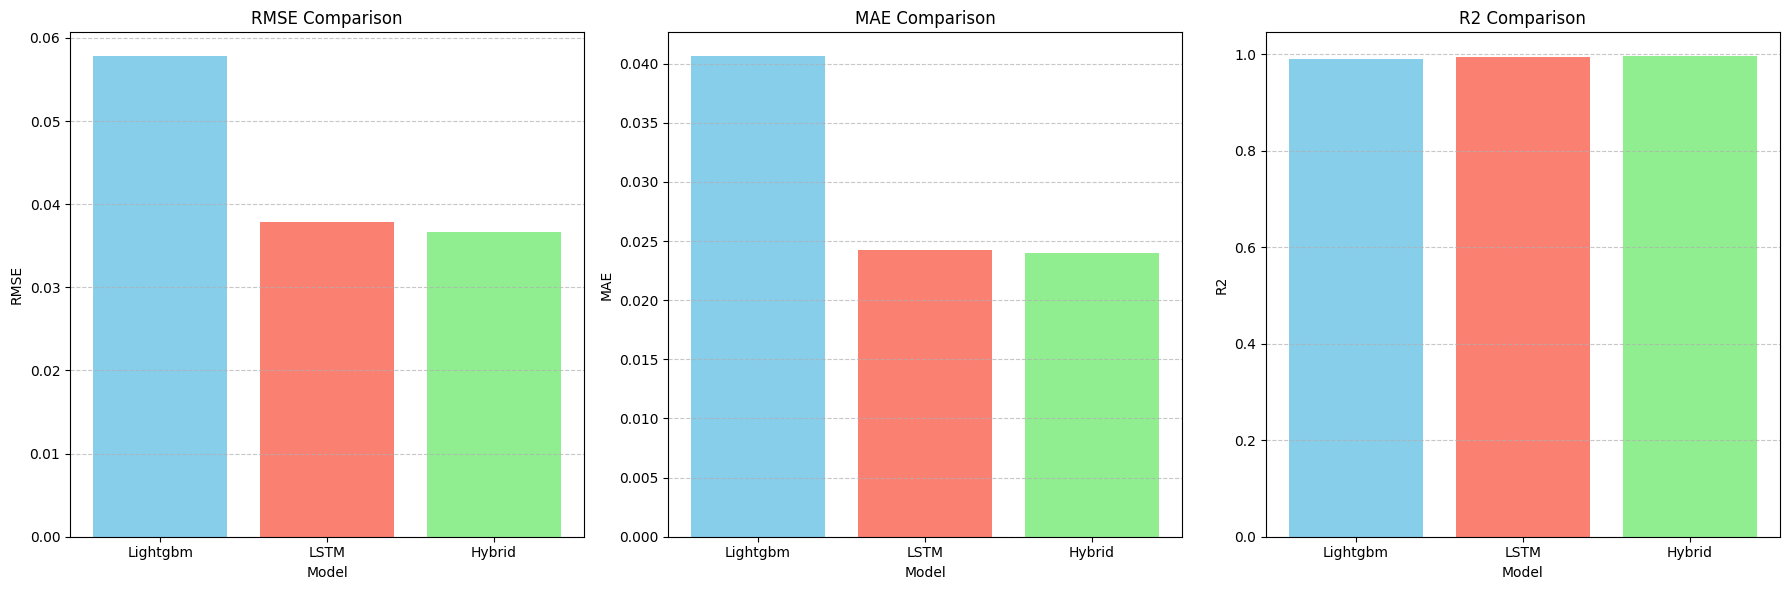

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_df = pd.DataFrame({
    'Model': ['Lightgbm', 'LSTM', 'Hybrid'],
    'RMSE': [np.mean(rmse_list_lgbm), np.mean(rmse_list_lstm), np.mean(rmse_list_hybrid)],
    'MAE': [np.mean(mae_list_lgbm), np.mean(mae_list_lstm), np.mean(mae_list_hybrid)],
    'R2': [np.mean(r2_list_lgbm), np.mean(r2_list_lstm), np.mean(r2_list_hybrid)],
})


fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
    ax[i].bar(metrics_df['Model'], metrics_df[metric], color=['skyblue', 'salmon', 'lightgreen'])
    ax[i].set_title(f'{metric} Comparison')
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Model')
    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




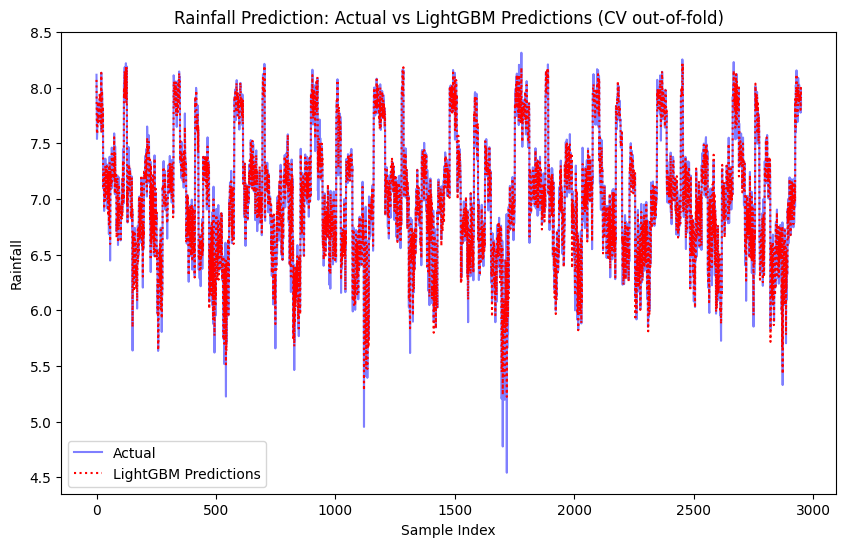

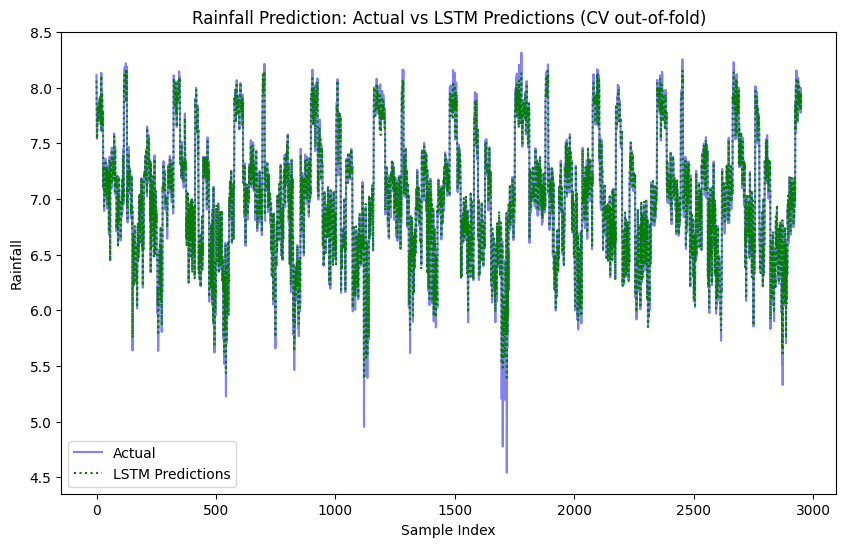

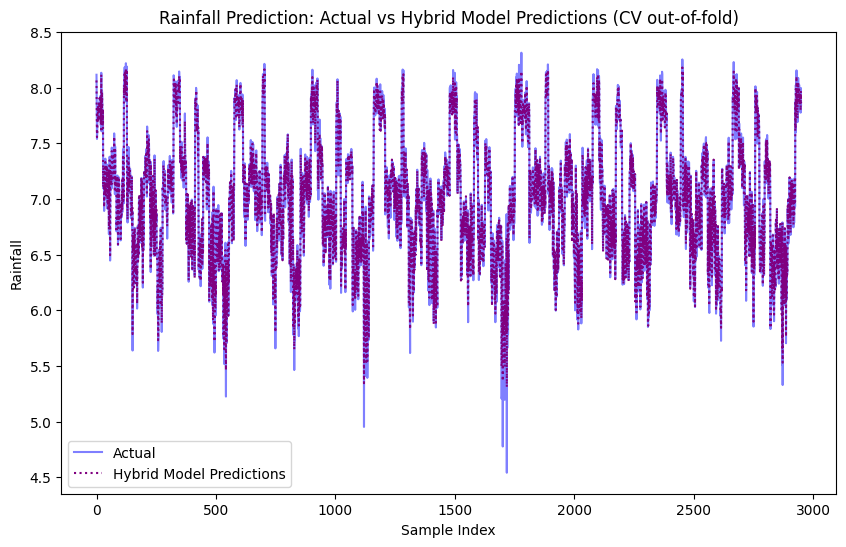

In [16]:
min_length = min(len(y_val_full), len(hybrid_val_preds_full))
plt.figure(figsize=(10, 6))
plt.plot(y_val_full[:min_length], label='Actual', color='blue', alpha=0.5)
plt.plot(lgbm_val_preds_full[:min_length], label='LightGBM Predictions', color='red', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs LightGBM Predictions (CV out-of-fold)")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_val_full[:min_length], label='Actual', color='blue', alpha=0.5)
plt.plot(lstm_val_preds_full[:min_length], label='LSTM Predictions', color='green', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs LSTM Predictions (CV out-of-fold)")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_val_full[:min_length], label='Actual', color='blue', alpha=0.5)
plt.plot(hybrid_val_preds_full[:min_length], label='Hybrid Model Predictions', color='purple', linestyle='dotted')
plt.legend()
plt.title("Rainfall Prediction: Actual vs Hybrid Model Predictions (CV out-of-fold)")
plt.xlabel("Sample Index")
plt.ylabel("Rainfall")
plt.show()

